In [1]:
!pip install efficientnet_pytorch 


  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=6206b8966a6b656aaf16ed2023d538aeb32361d739dabc51070f02ea5d4be094
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import utils
import torch.nn as nn
import torch.optim as optim
# from efficientnet_pytorch import EfficientNet
from PIL import Image
from sklearn.metrics import roc_curve, auc, confusion_matrix
import torch.nn.functional as F
from torchvision.models import vgg19
from torch.cuda.amp import GradScaler, autocast
import albumentations as A
from albumentations.pytorch import ToTensorV2
import functools
import random
from torchvision.utils import save_image
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import tqdm
from torchvision.transforms.functional import to_pil_image
from efficientnet_pytorch import EfficientNet


In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LR_IMAGE_PATH = "/kaggle/input/super-res/Dataset 3B/Dataset/LR"
HR_IMAGE_PATH = "/kaggle/input/super-res/Dataset 3B/Dataset/HR"

LEARNING_RATE = .0001
NUM_EPOCHS = 10
BATCH_SIZE = 32
NUM_WORKERS = 4
HIGH_RES = 128
LOW_RES = HIGH_RES // 2
IMG_CHANNELS = 1

random_seed = 42
random.seed(random_seed)


In [4]:
def transpose_channels(image, **kwargs):
    return np.transpose(image, (1, 2, 0))


highres_transform = A.Compose(
    [
        
        # A.Normalize(mean=[ 0.5], std=[.5]),
        # A.CenterCrop(120,120),
        ToTensorV2(),
    ]
)

lowres_transform = A.Compose(
    [
        # A.Normalize(mean=[ 0], std=[ 1]),
        # A.CenterCrop(120,120),
        ToTensorV2(),
    ]
)


both_transforms = A.Compose(
    [
        A.Lambda(image=transpose_channels),
#         A.HorizontalFlip(p=0.5),
#         A.RandomRotate90(p=0.5),
    ]
)

In [5]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, hr_folder, lr_folder, transform=None, hr_transform=None, lr_transform=None):
        self.hr_folder = hr_folder
        self.lr_folder = lr_folder
        self.transform = transform
        self.hr_transform = hr_transform
        self.lr_transform = lr_transform

        # Assuming HR and LR files have the same names in their respective folders
        self.file_list_hr = sorted(os.listdir(self.hr_folder))
        self.file_list_lr = sorted(os.listdir(self.lr_folder))

    def __len__(self):
        return min(len(self.file_list_hr), len(self.file_list_lr))

    def __getitem__(self, idx):
        hr_path = os.path.join(self.hr_folder, self.file_list_hr[idx])
        lr_path = os.path.join(self.lr_folder, self.file_list_lr[idx])

        hr_array = np.load(hr_path)
        lr_array = np.load(lr_path)

        # Apply transformations on both LR and HR images
        if self.transform:
            lr_array, hr_array = self.transform(image=lr_array)["image"], self.transform(image=hr_array)["image"]

        # Apply separate transformations on HR images
        if self.hr_transform:
            hr_array = self.hr_transform(image=hr_array)["image"]

        # Apply separate transformations on LR images
        if self.lr_transform:
            lr_array = self.lr_transform(image=lr_array)["image"]

        return lr_array, hr_array


In [6]:

dataset = CustomDataset(
    hr_folder=LR_IMAGE_PATH,
    lr_folder=HR_IMAGE_PATH,
    transform=both_transforms,  # Apply both_transforms on both LR and HR images
    hr_transform=highres_transform,  # Apply highres_transform on HR images
    lr_transform=lowres_transform,  # Apply lowres_transform on LR images
)



In [7]:
# Split the dataset into training and validation sets
train_indices, val_indices = train_test_split(
    list(range(len(dataset))),
    test_size=0.1,
    random_state=42
)

In [8]:
# Create training and validation datasets
val_dataset = torch.utils.data.Subset(dataset, val_indices)
dataset = torch.utils.data.Subset(dataset, train_indices)


In [9]:
print(len(dataset),len(val_dataset))


270 30


In [10]:
train_loader = DataLoader(dataset,  shuffle=True, num_workers=1)
val_loader = DataLoader(val_dataset , shuffle=False, num_workers=1)


In [11]:
batch_demo = next(iter(val_loader))
batch_demo[0].shape

torch.Size([1, 1, 128, 128])

In [12]:
batch_demo[1].shape

torch.Size([1, 1, 64, 64])

In [13]:
hr_images, lr_images = zip(*[(hr, lr) for hr, lr in val_loader])


In [22]:
class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        discriminator=False,
        use_act=True,
        use_bn=True,
        **kwargs,
    ):
        super().__init__()
        self.use_act = use_act
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs, bias=not use_bn)
        self.bn = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.act = (
            nn.LeakyReLU(0.2, inplace=True)
            if discriminator
            else nn.PReLU(num_parameters=out_channels)
        )

    def forward(self, x):
        x = x.to(self.cnn.weight.dtype)
        return self.act(self.bn(self.cnn(x))) if self.use_act else self.bn(self.cnn(x))


class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_c, in_c * scale_factor ** 2, 3, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)  # in_c * 4, H, W --> in_c, H*2, W*2
        self.act = nn.PReLU(num_parameters=in_c)

    def forward(self, x):
        return self.act(self.ps(self.conv(x)))


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.block1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.block2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_act=False,
        )

    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        return out + x

In [23]:
class Generator(nn.Module):
    def __init__(self, in_channels=1, num_channels=64, num_blocks=16):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=9, stride=1, padding=4, use_bn=False)
        self.residuals = nn.Sequential(*[ResidualBlock(num_channels) for _ in range(num_blocks)])
        self.convblock = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_act=False)
        self.upsamples = nn.Sequential(UpsampleBlock(num_channels, 2))
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial = self.initial(x)
        x = self.residuals(initial)
        x = self.convblock(x) + initial
        x = self.upsamples(x)
        return self.final(x) # torch.tanh(self.final(x))

In [24]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=1, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride=1 + idx % 2,
                    padding=1,
                    discriminator=True,
                    use_act=True,
                    use_bn=False if idx == 0 else True,
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(512*6*6, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        x = self.blocks(x)
        return self.classifier(x)

In [25]:
class EfficientNetLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = model= EfficientNet.from_pretrained('efficientnet-b0').eval().to(DEVICE)
        # set channel to 1
        self.features = model._conv_stem = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)  # Set bias to False
        #load model weights from previous task
        self.features.load_state_dict(torch.load('/kaggle/input/efficient_net_weights/pytorch/weights/1/model_ckassification_weights.pth'),strict=False)
        self.loss = nn.MSELoss()
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        input = input.to(DEVICE)
        self.features  = self.features.to(input.device)
        efficientnet_input_features = self.features(input)
        efficientnet_target_features = self.features(target)
        return self.loss(efficientnet_input_features, efficientnet_target_features)


In [26]:
def calculate_metrics(img1, img2):
    ssim_value = ssim(img1, img2, data_range=1.0, full=False)
    psnr_value = psnr(img1, img2, data_range=1.0)
    mse_value = np.mean((img1 - img2) ** 2)
    return ssim_value, psnr_value, mse_value

def evaluate(val_loader, gen, output_folder, img):
    os.makedirs(output_folder, exist_ok=True)

    gen.eval()
    results = []
    total_ssim, total_psnr, total_mse = 0.0, 0.0, 0.0

    for batch_idx, ( hr_images,lr_images) in enumerate(val_loader):
        for i in range(len(lr_images)):
            lr_image, hr_image = lr_images[i].unsqueeze(0).to(DEVICE), hr_images[i].unsqueeze(0).to(DEVICE)
            
            with torch.no_grad():
                upscaled_img = gen(lr_image)

            # Convert tensors to NumPy arrays
            lr_image_np = lr_image.squeeze().cpu().numpy()
            hr_image_np = hr_image.squeeze().cpu().numpy()
            upscaled_img_np = upscaled_img.squeeze().cpu().numpy()

            # Calculate SSIM, PSNR, and MSE
            ssim_value, psnr_value, mse_value = calculate_metrics(hr_image_np, upscaled_img_np)
            results.append((ssim_value, psnr_value, mse_value))
            # Accumulate SSIM, PSNR, and MSE for mean calculation
            total_ssim += ssim_value
            total_psnr += psnr_value
            total_mse += mse_value

    gen.train()

    # Calculate mean SSIM, PSNR, and MSE
    mean_ssim = total_ssim / len(results)
    mean_psnr = total_psnr / len(results)
    mean_mse = total_mse / len(results)

    # Write results to a text file
    print(f"Mean SSIM = {mean_ssim:.4f}, Mean PSNR = {mean_psnr:.4f}, Mean MSE = {mean_mse:.4f}\n") 


**traing with the pretrained  genarator with l2 loss, so basically finetuing a deep residual SR model with mse**


In [27]:
train_losses = []
val_losses = []
def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, EfficientNet_loss):
    train_loss = 0
    l2_losses = []
    adversarial_losses = []
    efficientnet_losses = []
    correct = 0
    total = 0

    for idx, (high_res, low_res) in enumerate(loader):
                
        high_res = high_res.to(DEVICE).float()
        low_res = low_res.to(DEVICE).float()   
        fake = gen(low_res)
        l2_loss = mse(fake, high_res)
        gen_loss =  l2_loss 
        train_loss += gen_loss.item()
        l2_losses.append(l2_loss.item())    
        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

    train_loss /= len(loader)
    train_losses.append(train_loss)
    
    l2_loss_mean = sum(l2_losses) / len(l2_losses)
    
    print(f"Training, Train Loss: {train_loss:.8f}, L2 Loss: {l2_loss_mean:.8f}")
    
    # Validation
    gen.eval()  # Set the generator to evaluation mode for validation
    with torch.no_grad():
        val_loss = 0.0
        l2_losses = []
        adversarial_losses = []
        efficientnet_losses = []
        for val_idx, (val_high_res,val_low_res) in enumerate(val_loader):
            val_low_res = val_low_res.to(DEVICE).float()
            val_high_res = val_high_res.to(DEVICE).float()
            val_fake = gen(val_low_res)
            l2_loss = mse(val_fake, val_high_res)
    
            gen_loss =  l2_loss 

            val_loss += gen_loss.item()
            
            l2_losses.append(l2_loss.item())


        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        l2_loss_mean = sum(l2_losses) / len(l2_losses)

        print(f"Validation, Val Loss: {val_loss:.8f}, L2 Loss: {l2_loss_mean:.8f}")#, Adversarial Loss: {adversarial_loss_mean:.8f}, EfficientNet Loss: {efficientnet_loss_mean:.8f}")


In [28]:
LEARNING_RATE = .0001
NUM_EPOCHS = 10
BATCH_SIZE = 64
gen = Generator(in_channels=1).to(DEVICE)
gen.load_state_dict(torch.load('/kaggle/input/esrgan/pytorch/srgan/10/gen_pretrain_l2_001_e3.pth'),strict = False)

disc = Discriminator(in_channels=1).to(DEVICE)
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
EfficientNet_loss =EfficientNetLoss().to(DEVICE)



Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 49.3MB/s]


Loaded pretrained weights for efficientnet-b0


In [29]:
for epoch in range(NUM_EPOCHS):
    print(epoch)
    train_fn(train_loader, disc, gen, opt_gen, opt_disc, mse, bce, EfficientNet_loss)
    torch.save(gen.state_dict(), str(epoch)+'gen_model1_task3b.pth')
    evaluate(val_loader, gen, output_folder = 'result/epoch'+str(epoch),img = True)
    



0
Training, Train Loss: 0.00149636, L2 Loss: 0.00149636
Validation, Val Loss: 0.00127515, L2 Loss: 0.00127515
Mean SSIM = 0.7321, Mean PSNR = 32.0217, Mean MSE = 0.0013

1
Training, Train Loss: 0.00152340, L2 Loss: 0.00152340
Validation, Val Loss: 0.00080920, L2 Loss: 0.00080920
Mean SSIM = 0.8154, Mean PSNR = 33.8992, Mean MSE = 0.0008

2
Training, Train Loss: 0.00138591, L2 Loss: 0.00138591
Validation, Val Loss: 0.00085964, L2 Loss: 0.00085964
Mean SSIM = 0.7140, Mean PSNR = 33.4460, Mean MSE = 0.0009

3
Training, Train Loss: 0.00132774, L2 Loss: 0.00132774
Validation, Val Loss: 0.00076080, L2 Loss: 0.00076080
Mean SSIM = 0.8364, Mean PSNR = 34.8135, Mean MSE = 0.0008

4
Training, Train Loss: 0.00128822, L2 Loss: 0.00128822
Validation, Val Loss: 0.00087606, L2 Loss: 0.00087606
Mean SSIM = 0.8019, Mean PSNR = 33.4150, Mean MSE = 0.0009

5
Training, Train Loss: 0.00133540, L2 Loss: 0.00133540
Validation, Val Loss: 0.00076520, L2 Loss: 0.00076520
Mean SSIM = 0.8431, Mean PSNR = 34.5012,

Image 1 - SSIM: 0.8822, PSNR: 33.18,MSE: 0.0005


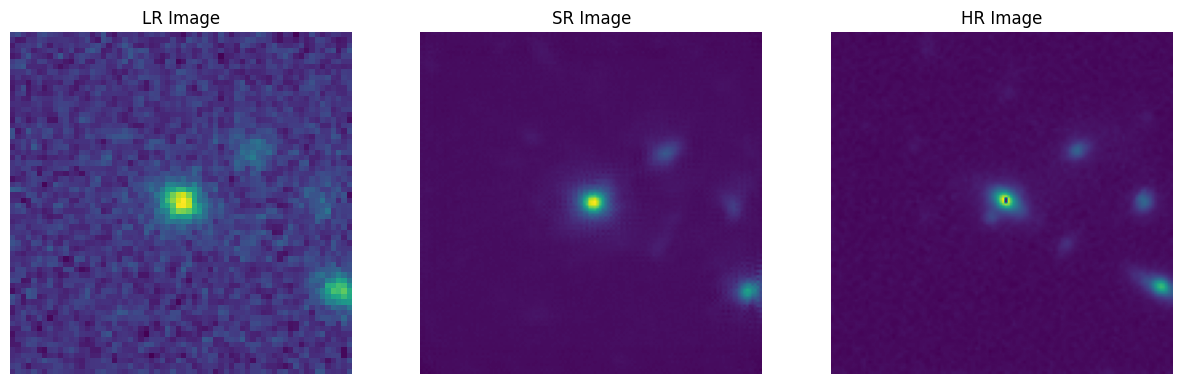

Image 2 - SSIM: 0.8822, PSNR: 33.18,MSE: 0.0005


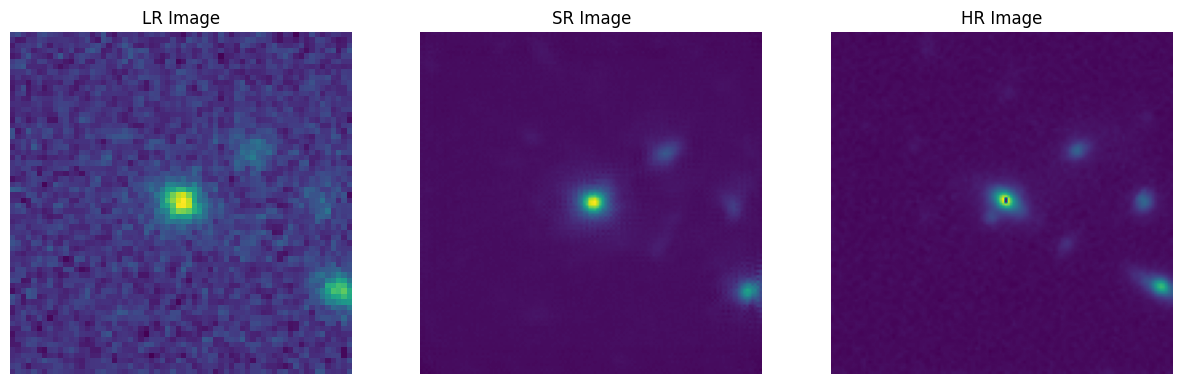

Image 3 - SSIM: 0.8822, PSNR: 33.18,MSE: 0.0005


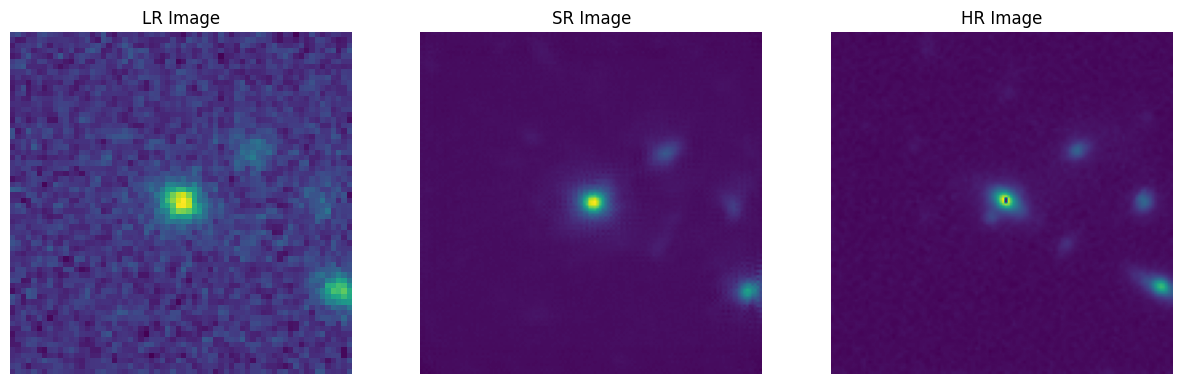

Image 4 - SSIM: 0.8822, PSNR: 33.18,MSE: 0.0005


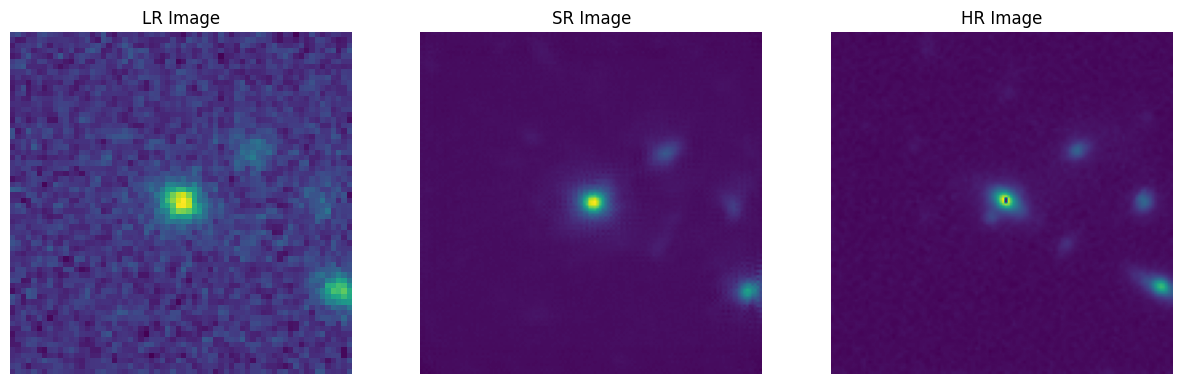

Image 5 - SSIM: 0.8822, PSNR: 33.18,MSE: 0.0005


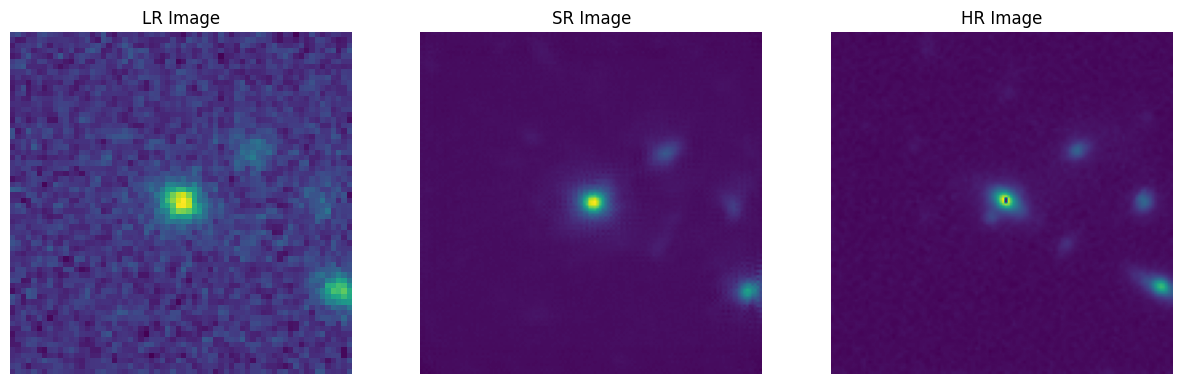

In [32]:
generator = Generator(in_channels=1).to(DEVICE)
generator.load_state_dict(torch.load('/kaggle/working/5gen_model1_task3b.pth'))

# Assuming val_loader returns individual LR and HR images
hr_images, lr_images = next(iter(val_loader))

# Generate SR images using the loaded generator
with torch.no_grad():
    sr_images = generator(lr_images.float().to(DEVICE))  # Add batch dimension

# Display LR vs SR vs HR triplets and calculate metrics
num_images = 5  # Display up to 5 images

for i in range(num_images):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(to_pil_image(lr_images.squeeze().cpu()))
    plt.title('LR Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(to_pil_image(sr_images.squeeze().cpu()))
    plt.title('SR Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(to_pil_image(hr_images.squeeze().cpu()))
    plt.title('HR Image')
    plt.axis('off')

    # Calculate and print SSIM and PSNR
    ssim_value, psnr_value, mse_value = calculate_metrics(sr_images.cpu().squeeze().numpy(), hr_images.cpu().squeeze().numpy())
    print(f"Image {i + 1} - SSIM: {ssim_value:.4f}, PSNR: {psnr_value:.2f},MSE: {mse_value:.4f}")

    plt.show()

    

**pre trained GAN SR**

In [33]:
train_losses = []
val_losses = []
def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, EfficientNet_loss):
    train_loss = 0
    l2_losses = []
    adversarial_losses = []
    efficientnet_losses = []
    correct = 0
    total = 0

    for idx, (high_res, low_res) in enumerate(loader):
                
        high_res = high_res.to(DEVICE).float()
        low_res = low_res.to(DEVICE).float()   

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        fake = gen(low_res)
        disc_real = disc(high_res)
        disc_fake = disc(fake.detach())
        disc_loss_real = bce(
            disc_real, torch.ones_like(disc_real) - 0.1 * torch.rand_like(disc_real)
        )
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = disc_loss_fake + disc_loss_real

        opt_disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        disc_fake = disc(fake)
        l2_loss = mse(fake, high_res)
        adversarial_loss =  bce(disc_fake, torch.ones_like(disc_fake))
        loss_for_efficientNet =  EfficientNet_loss(fake, high_res)
        gen_loss =   10 * l2_loss  + .006 * loss_for_efficientNet + .001 * adversarial_loss

        
        train_loss += gen_loss.item()
        l2_losses.append(l2_loss.item())
        adversarial_losses.append(adversarial_loss.item())
        efficientnet_losses.append(loss_for_efficientNet.item())
        
        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()
        
    train_loss /= len(loader)
    train_losses.append(train_loss)
    
    l2_loss_mean = sum(l2_losses) / len(l2_losses)
    adversarial_loss_mean = sum(adversarial_losses) / len(adversarial_losses)
    efficientnet_loss_mean = sum(efficientnet_losses) / len(efficientnet_losses)
    
    print(f"Training, Train Loss: {train_loss:.8f}, L2 Loss: {l2_loss_mean:.8f}, Adversarial Loss: {adversarial_loss_mean:.8f}, EfficientNet Loss: {efficientnet_loss_mean:.8f}, Discriminator Loss: {loss_disc.item():.8f}")
        
    # Validation
    gen.eval()  # Set the generator to evaluation mode for validation
    with torch.no_grad():
        val_loss = 0.0
        l2_losses = []
        adversarial_losses = []
        efficientnet_losses = []
        for val_idx, ( val_high_res,val_low_res) in enumerate(val_loader):
            val_low_res = val_low_res.to(DEVICE).float()
            val_high_res = val_high_res.to(DEVICE).float()
            val_fake = gen(val_low_res)
            l2_loss = mse(val_fake, val_high_res)
            adversarial_loss =  bce(disc(val_fake), torch.ones_like(disc(val_fake)))
            efficientnet_loss = EfficientNet_loss(val_fake, val_high_res)

            gen_loss = 10* l2_loss  + .006 * efficientnet_loss + .001 * adversarial_loss

            val_loss += gen_loss.item()
            
            l2_losses.append(l2_loss.item())
            adversarial_losses.append(adversarial_loss.item())
            efficientnet_losses.append(efficientnet_loss.item())

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        l2_loss_mean = sum(l2_losses) / len(l2_losses)
        adversarial_loss_mean = sum(adversarial_losses) / len(adversarial_losses)
        efficientnet_loss_mean = sum(efficientnet_losses) / len(efficientnet_losses)
        
        print(f"Validation, Val Loss: {val_loss:.8f}, L2 Loss: {l2_loss_mean:.8f}, Adversarial Loss: {adversarial_loss_mean:.8f}, EfficientNet Loss: {efficientnet_loss_mean:.8f}")

    


In [39]:
NUM_EPOCHS = 13
LEARNING_RATE = .000001
gen_2 = Generator(in_channels=1).to(DEVICE)
gen_2.load_state_dict(torch.load('/kaggle/input/esrgan/pytorch/srgan/10/3_gen_srgan_00001.pth'))

disc_2 = Discriminator(in_channels=1).to(DEVICE)
opt_gen = optim.Adam(gen_2.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc_2.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
EfficientNet_loss =EfficientNetLoss().to(DEVICE)



Loaded pretrained weights for efficientnet-b0


In [38]:
for epoch in range(NUM_EPOCHS):
    print(epoch)
    train_fn(train_loader, disc_2, gen_2, opt_gen, opt_disc, mse, bce, EfficientNet_loss)
    torch.save(gen_2.state_dict(), str(epoch)+'gen_model2_task3b.pth')
    evaluate(val_loader, gen_2, output_folder = 'result/epoch'+str(epoch),img = True)
    


0
Training, Train Loss: 0.01510799, L2 Loss: 0.00123251, Adversarial Loss: 2.78024935, EfficientNet Loss: 0.00044136, Discriminator Loss: 0.35265332
Validation, Val Loss: 0.01417172, L2 Loss: 0.00105201, Adversarial Loss: 3.64933439, EfficientNet Loss: 0.00037685
Mean SSIM = 0.6424, Mean PSNR = 31.7021, Mean MSE = 0.0011

1
Training, Train Loss: 0.01515099, L2 Loss: 0.00122447, Adversarial Loss: 2.90364476, EfficientNet Loss: 0.00043716, Discriminator Loss: 0.12337044
Validation, Val Loss: 0.01446628, L2 Loss: 0.00093138, Adversarial Loss: 5.15039957, EfficientNet Loss: 0.00033996
Mean SSIM = 0.6706, Mean PSNR = 32.3274, Mean MSE = 0.0009

2
Training, Train Loss: 0.01552149, L2 Loss: 0.00123553, Adversarial Loss: 3.16358427, EfficientNet Loss: 0.00044156, Discriminator Loss: 0.43201712
Validation, Val Loss: 0.01311102, L2 Loss: 0.00098961, Adversarial Loss: 3.21284434, EfficientNet Loss: 0.00035471
Mean SSIM = 0.6773, Mean PSNR = 32.6519, Mean MSE = 0.0010

3
Training, Train Loss: 0.01

Image 1 - SSIM: 0.8421, PSNR: 31.21,MSE: 0.0008


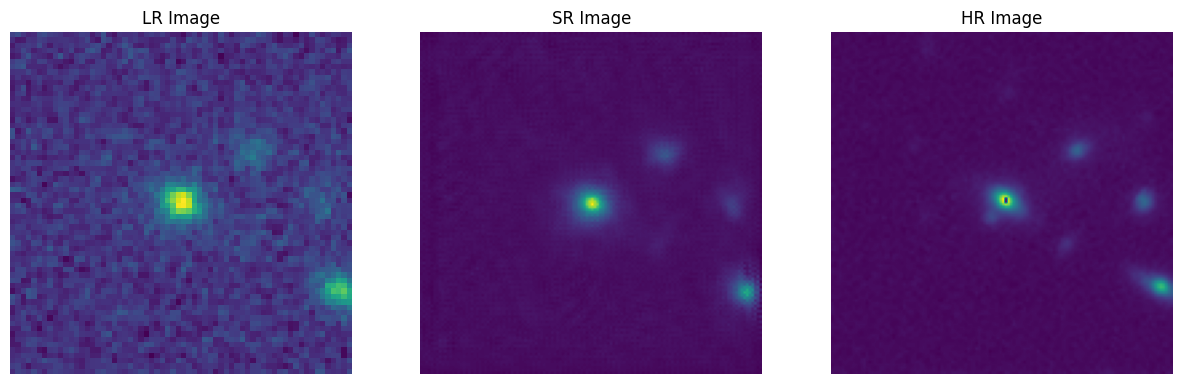

Image 2 - SSIM: 0.8421, PSNR: 31.21,MSE: 0.0008


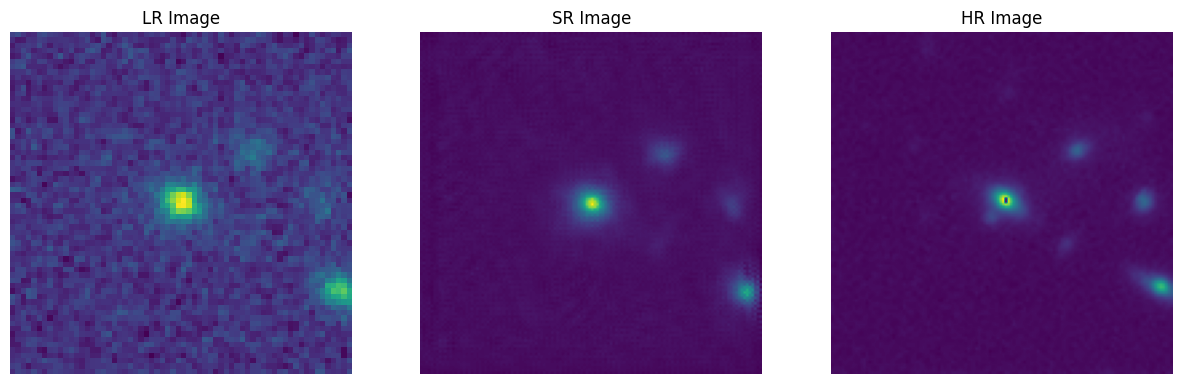

Image 3 - SSIM: 0.8421, PSNR: 31.21,MSE: 0.0008


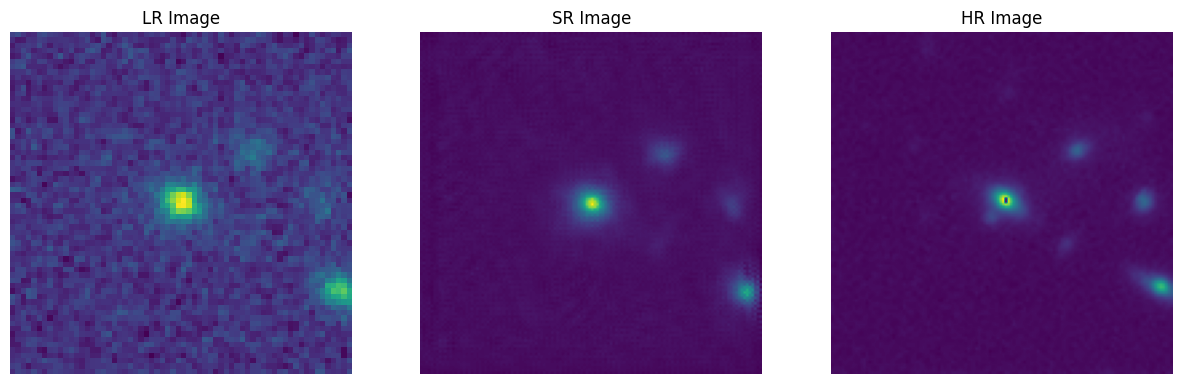

Image 4 - SSIM: 0.8421, PSNR: 31.21,MSE: 0.0008


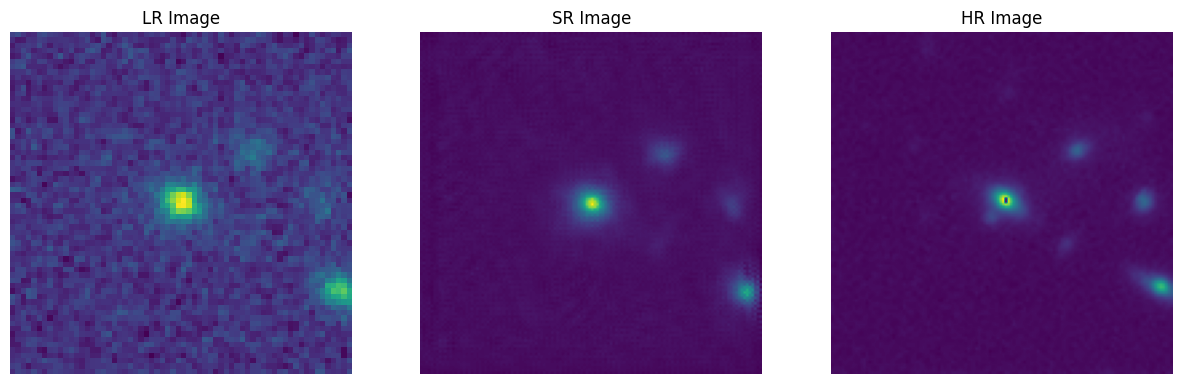

Image 5 - SSIM: 0.8421, PSNR: 31.21,MSE: 0.0008


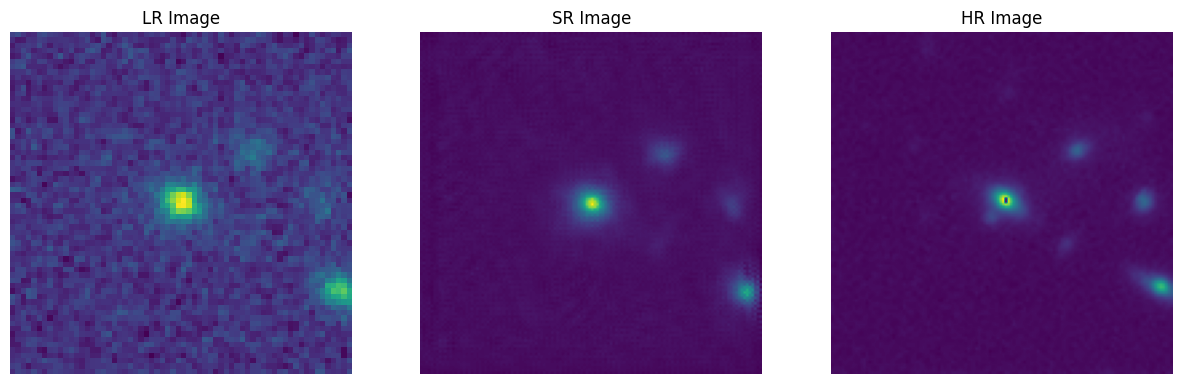

In [37]:
# Assuming val_loader returns individual LR and HR images
hr_images, lr_images = next(iter(val_loader))

# Generate SR images using the loaded generator
with torch.no_grad():
    sr_images = gen_2(lr_images.float().to(DEVICE))  # Add batch dimension

# Display LR vs SR vs HR triplets and calculate metrics
num_images = 5  # Display up to 5 images

for i in range(num_images):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(to_pil_image(lr_images.squeeze().cpu()))
    plt.title('LR Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(to_pil_image(sr_images.squeeze().cpu()))
    plt.title('SR Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(to_pil_image(hr_images.squeeze().cpu()))
    plt.title('HR Image')
    plt.axis('off')

    # Calculate and print SSIM and PSNR
    ssim_value, psnr_value, mse_value = calculate_metrics(sr_images.cpu().squeeze().numpy(), hr_images.cpu().squeeze().numpy())
    print(f"Image {i + 1} - SSIM: {ssim_value:.4f}, PSNR: {psnr_value:.2f},MSE: {mse_value:.4f}")

    plt.show()


In [22]:
!rm -rf /kaggle/working/*